# FODO optics

This will demonstrate how to scan symmetrically and asymetrically the quadruople strengths in a standard FODO lattice.

Later we will optimize for particular average beta function.

Finally, we will track a beam and gather statistics from the particles.

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import os

%config InlineBackend.figure_format = 'retina'

In [2]:
tao = Tao(
    "-init $ACC_ROOT_DIR/bmad-doc/tao_examples/fodo/tao.init -lat $ACC_ROOT_DIR/bmad-doc/tao_examples/fodo/fodo.bmad -noplot"
)

In [3]:
def add_info(d):
    twiss1 = tao.ele_twiss("q1")
    twiss2 = tao.ele_twiss("q2")

    d["mean_beta_a"] = (twiss1["beta_a"] + twiss2["beta_a"]) / 2
    d["mean_beta_b"] = (twiss1["beta_b"] + twiss2["beta_b"]) / 2
    d["phi_a"] = twiss2["phi_a"]
    d["phi_b"] = twiss2["phi_b"]
    return d

In [4]:
%%tao
sho lat

-------------------------
Tao> sho lat
# Values shown are for the Downstream End of each Element (Girder at ref point):
# Index  name      key                       s       l    beta   phi_a    eta   orbit    beta   phi_b    eta   orbit  Track
#                                                            a   [2pi]      x  x [mm]       b   [2pi]      y  y [mm]  State
      0  BEGINNING Beginning_Ele         0.000     ---    0.67   0.000   0.00   0.000    3.22   0.000   0.00   0.000  Alive
      1  P1        Pipe                  0.900   0.900    3.22   0.105   0.00   0.000    0.67   0.105   0.00   0.000  Alive
      2  Q1        Quadrupole            1.000   0.100    3.22   0.110   0.00   0.000    0.67   0.129   0.00   0.000  Alive
      3  P1        Pipe                  1.900   0.900    0.67   0.215   0.00   0.000    3.22   0.235   0.00   0.000  Alive
      4  Q2        Quadrupole            2.000   0.100    0.67   0.239   0.00   0.000    3.22   0.239   0.00   0.000  Alive
      5  END

## Symmetric FODO

In [5]:
def set_kx(k1):
    cmds = [f"set ele q1 k1 = {k1}", f"set ele q2 k1 = {-k1}"]

    d = {}
    try:
        tao.cmds(cmds)
        tao.cmd("set global lattice_calc_on = T")
        d["good"] = True
        add_info(d)
    except RuntimeError:
        d["good"] = False

    return d


x = set_kx(1.4142136e01)
KEYS = x.keys()
x

{'good': True,
 'mean_beta_a': 1.9442223177869156,
 'mean_beta_b': 1.9442223177869151,
 'phi_a': 1.50388821541239,
 'phi_b': 1.5038882154124}

In [6]:
# Scan k1
n1 = 20
qvec1 = np.linspace(1, 25, n1)

RESULTS = []

# tao.cmd('set global plot_on = F')
for k in qvec1:
    res = set_kx(k)
    RESULTS.append(res)
# tao.cmd('set global plot_on = T')

In [7]:
# Reshape data
DAT = {}
for key in KEYS:
    print(key)
    x = []
    for res in RESULTS:
        if key in res:
            x.append(res[key])
        else:
            x.append(np.nan)
    DAT[key] = np.array(x)

good
mean_beta_a
mean_beta_b
phi_a
phi_b


In [8]:
DAT.keys()

dict_keys(['good', 'mean_beta_a', 'mean_beta_b', 'phi_a', 'phi_b'])

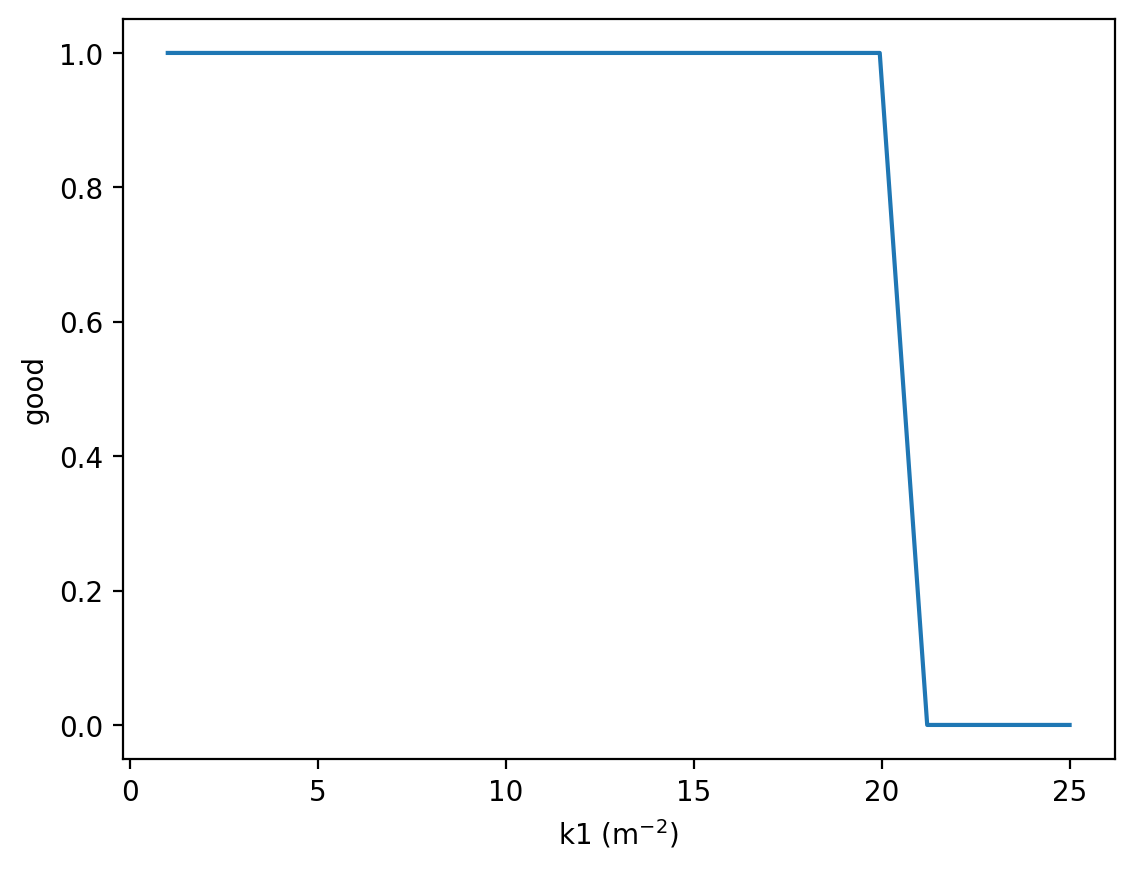

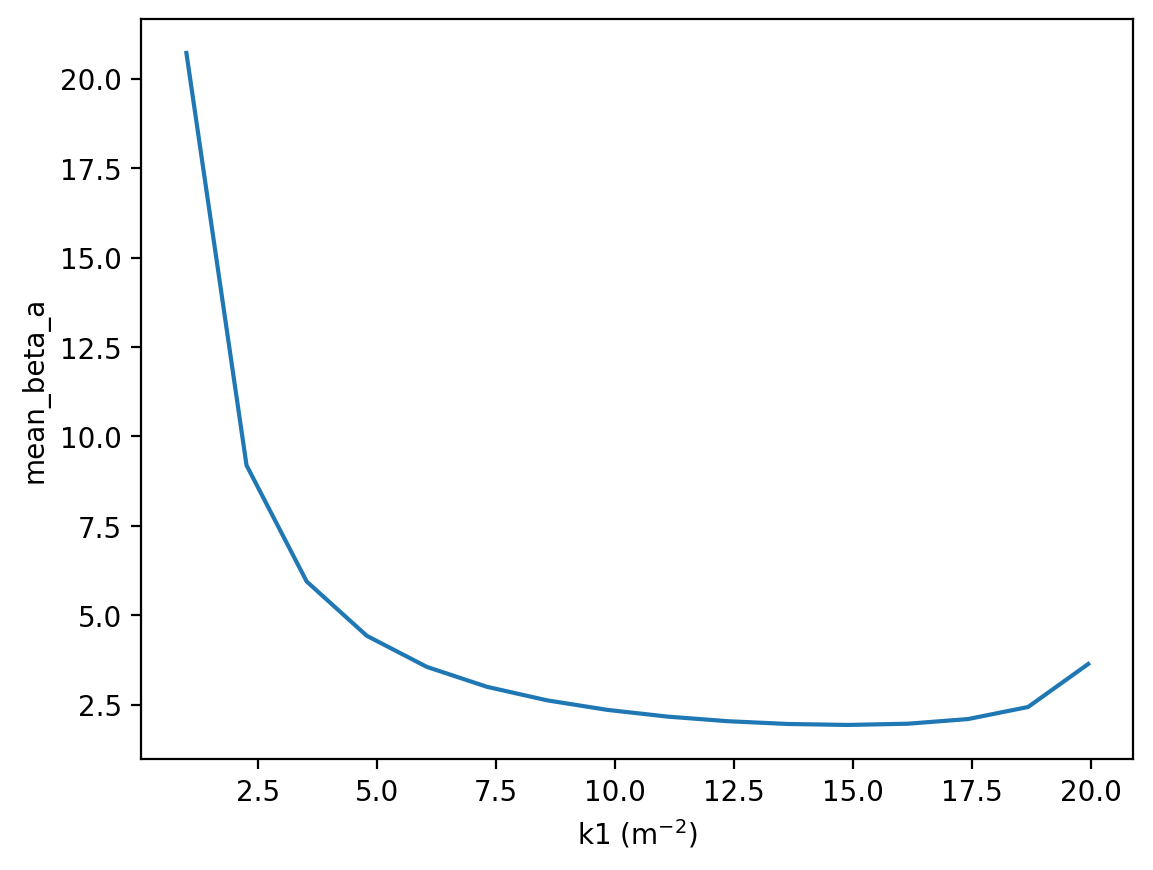

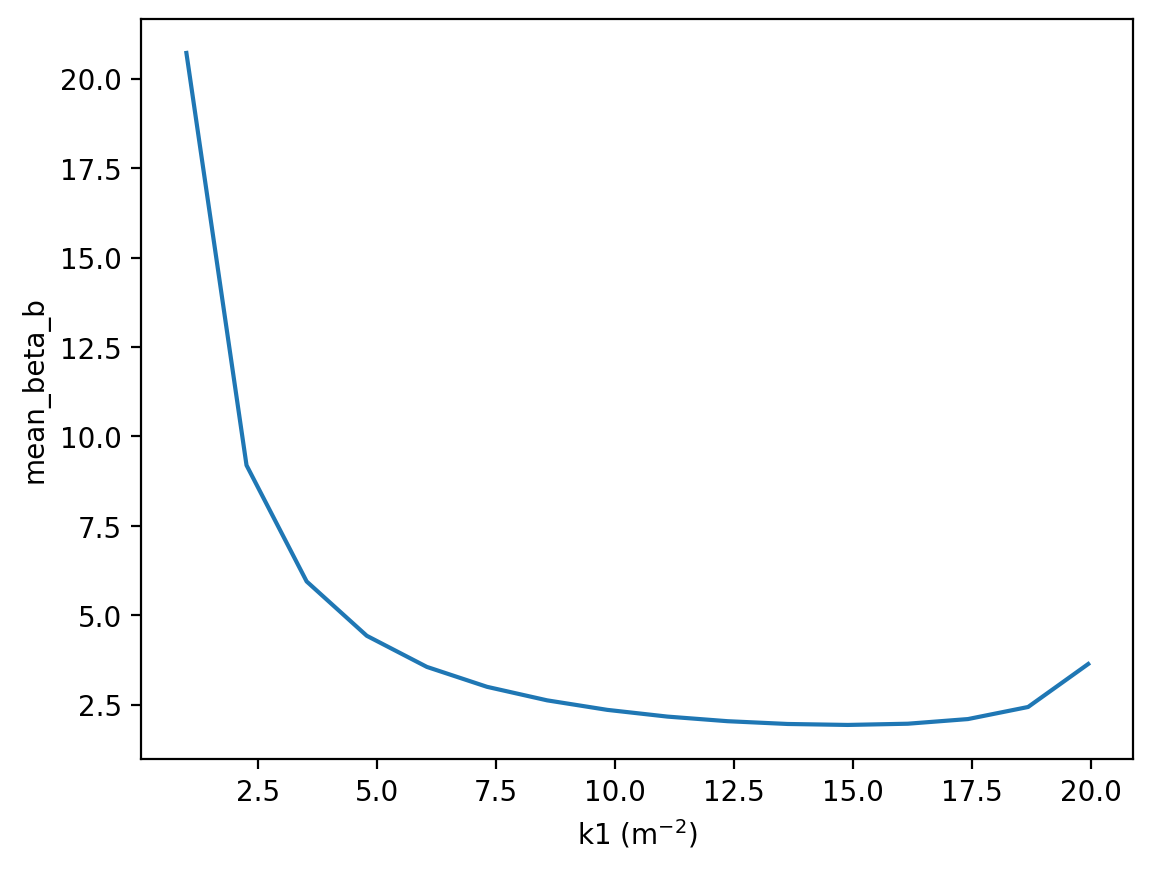

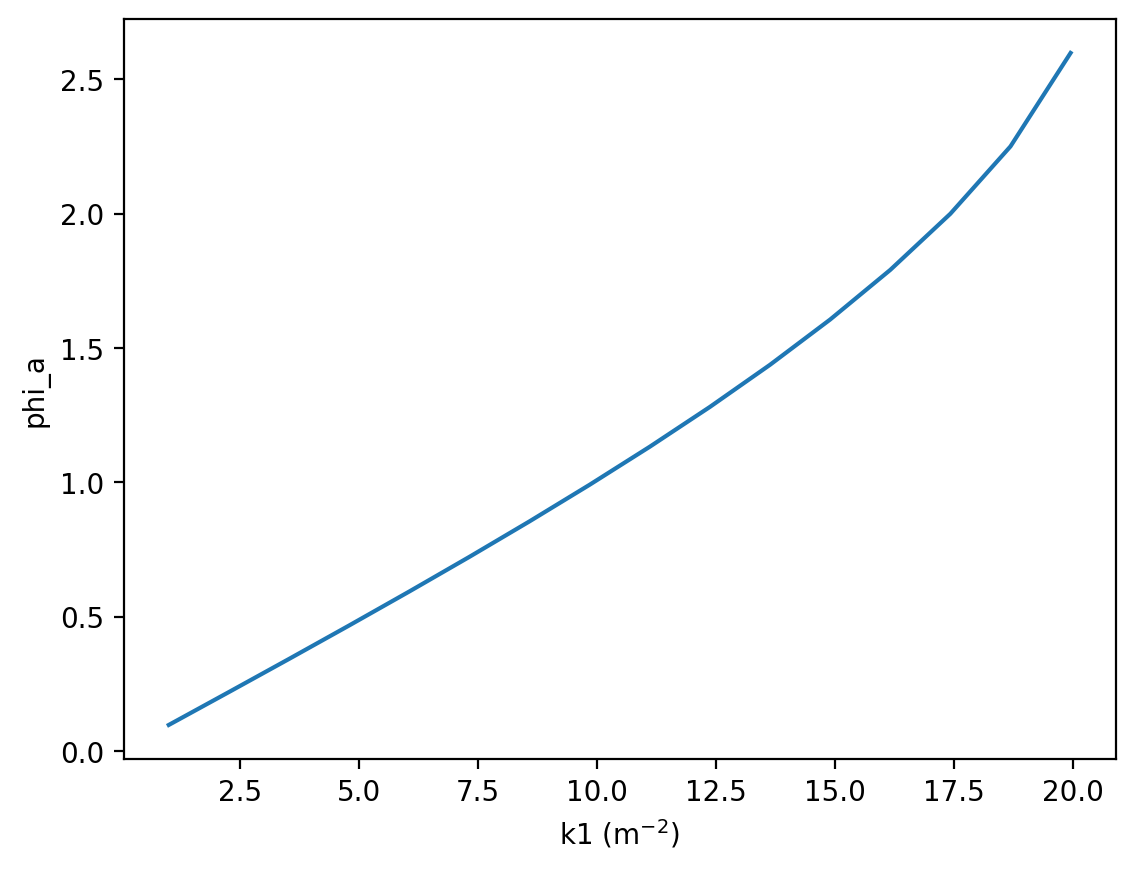

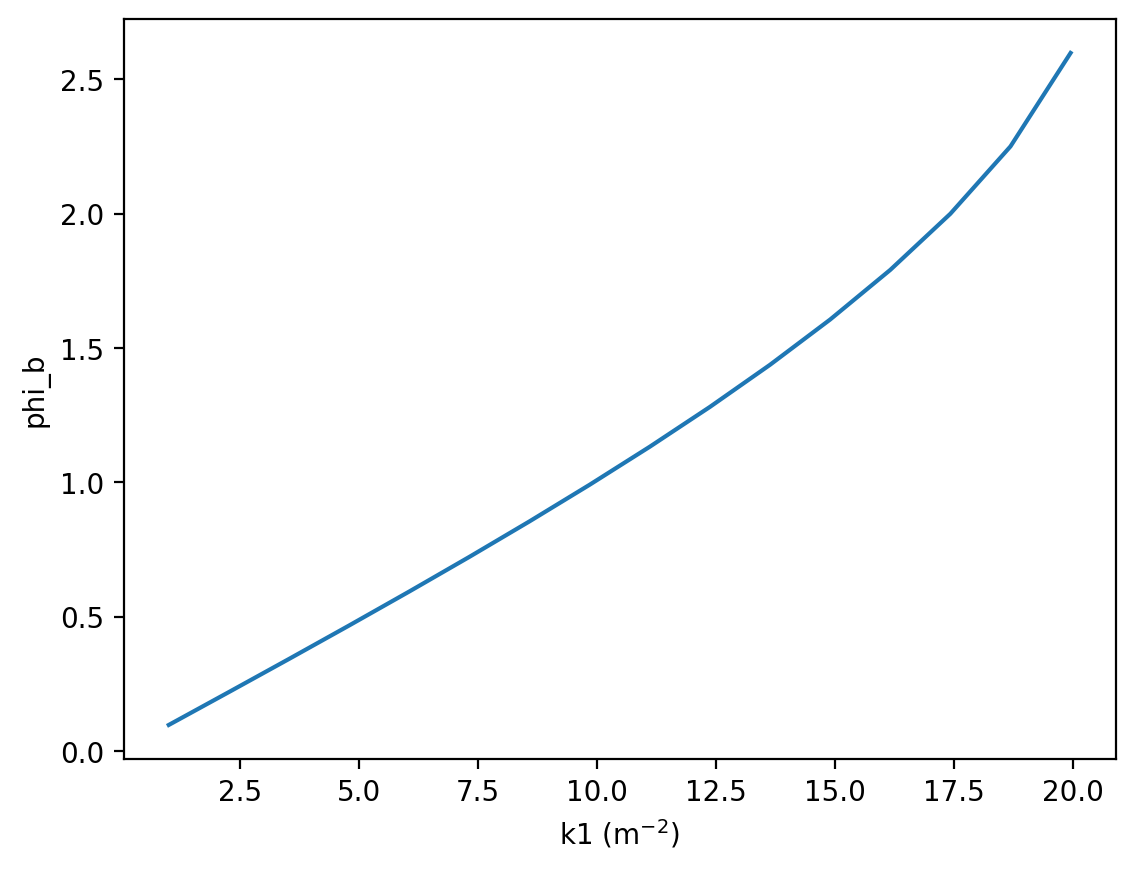

In [9]:
for key in KEYS:
    plt.plot(qvec1, DAT[key])
    plt.ylabel(key)
    plt.xlabel(r"k1 (m$^{-2}$)")
    plt.show()

In [10]:
%%tao
sho dat

-------------------------
Tao> sho dat

  Name                                 Using for Optimization
  fodo.betas[1:2]                                Using: 1:2
  fodo.stability[1:1]                            Using: 1
-------------------------
Tao> 


# Asymmetric FODO

Scan k1 for each quad

In [11]:
def set_k(k1, k2):
    cmds = [f"set ele q1 k1 = {k1}", f"set ele q2 k1 = {-k2}"]

    d = {}
    try:
        tao.cmds(cmds)
        tao.cmd("set global lattice_calc_on = T")
        d["good"] = True
        add_info(d)
    except RuntimeError:
        d["good"] = False

    return d


x = set_k(1.4142136e01, 1.4142136e01)
KEYS = x.keys()
x

{'good': True,
 'mean_beta_a': 1.9442223177869156,
 'mean_beta_b': 1.9442223177869151,
 'phi_a': 1.50388821541239,
 'phi_b': 1.5038882154124}

In [12]:
set_k(1, 1)

{'good': True,
 'mean_beta_a': 20.7230562019829,
 'mean_beta_b': 20.7230562019829,
 'phi_a': 0.0966467384116868,
 'phi_b': 0.0966467384116869}

In [13]:
n1 = 50
n2 = 60
qvec1 = np.linspace(1, 15, n1)
qvec2 = np.linspace(1, 15, n2)
K1, K2 = np.meshgrid(qvec1, qvec2, indexing="ij")

fK1 = K1.flatten()
fK2 = K2.flatten()

In [14]:
%%time
# Make data

tao.cmd("set global plot_on = F")

RESULTS = []
for k1, k2 in zip(fK1, fK2):
    res = set_k(k1, k2)
    #    print(res)
    RESULTS.append(res)


# tao.cmd('set global plot_on = T')

CPU times: user 2.43 s, sys: 360 ms, total: 2.79 s
Wall time: 2.79 s


In [15]:
# Reshape data
DAT = {}
for key in RESULTS[0]:
    print(key)
    x = []
    for res in RESULTS:
        if key in res:
            x.append(res[key])
        else:
            x.append(np.nan)

    DAT[key] = np.array(x).reshape(n1, n2)

good
mean_beta_a
mean_beta_b
phi_a
phi_b


# Plots

In [16]:
NICE = {}
NICE["mean_beta_a"] = r"$<\beta_x>$"
NICE["mean_beta_b"] = r"$<\beta_y>$"


def nice(key):
    if key in NICE:
        return NICE[key]
    return key

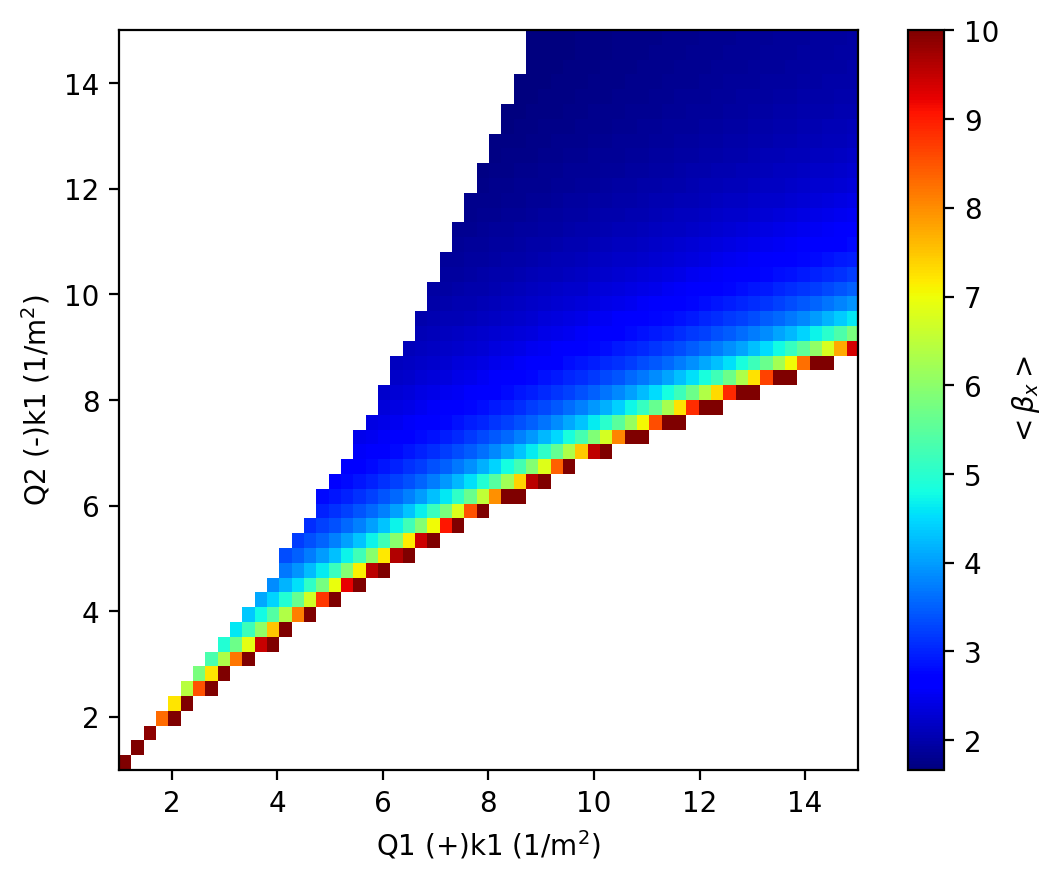

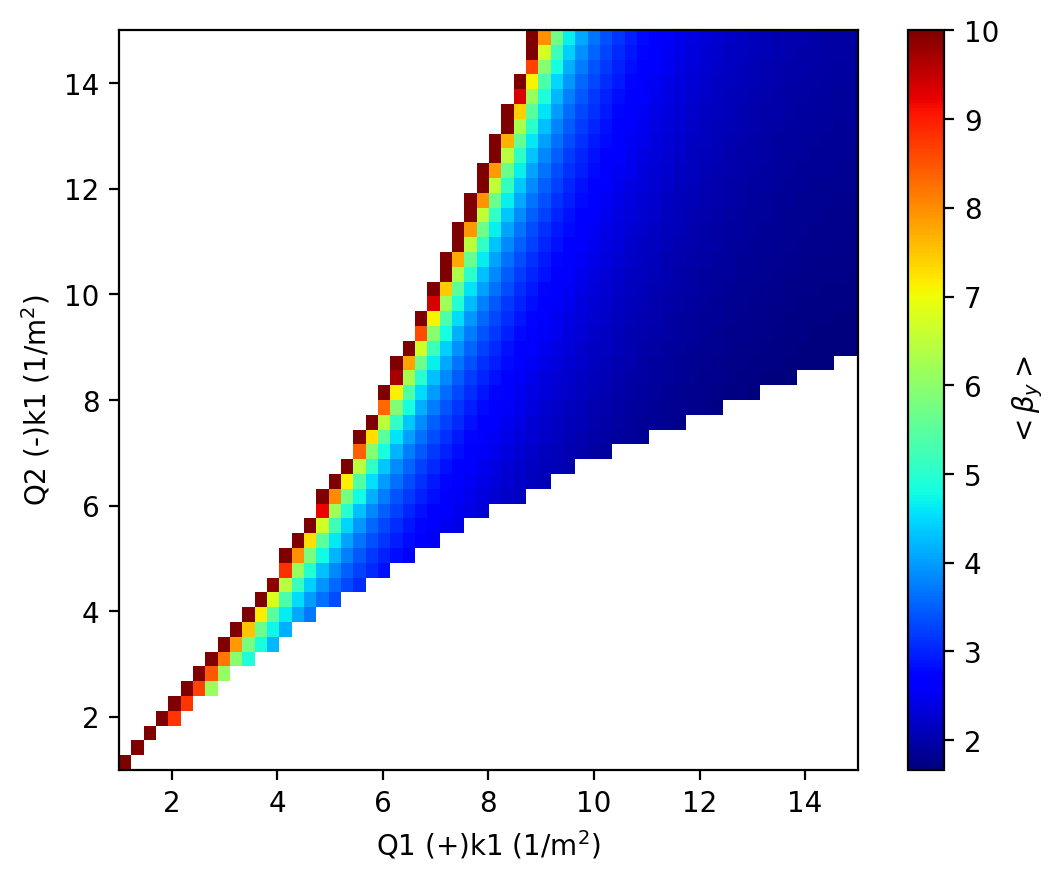

In [17]:
# fig, ax = plt.subplots(figsize=(10,8))


def plot1(key):
    plt.imshow(
        DAT[key],
        origin="lower",
        extent=[qvec1.min(), qvec1.max(), qvec2.min(), qvec2.max()],
        cmap="jet",
        vmax=10,
    )
    plt.xlabel("Q1 (+)k1 (1/m$^2$)")
    plt.ylabel("Q2 (-)k1 (1/m$^2$)")
    plt.colorbar(label=nice(key))
    plt.show()


plot1("mean_beta_a")
plot1("mean_beta_b")

# Optimize for some special beta functions

In [18]:
def optimize(beta_a, beta_b):
    cmds = f"""
alias setbetas
veto var *
set lattice model=design
veto dat *
use dat fodo.betas[1,2]
use dat fodo.stability
set dat fodo.betas[1]|meas={beta_a}
set dat fodo.betas[2]|meas={beta_b}
use var quad
run
show var -bmad -good
    """
    lines = tao.cmds(
        cmds.split("\n"),
        suppress_lattice_calc=False,
        suppress_plotting=False,
        raises=False,
    )

    # Twiss at Q1
    T = tao.ele_twiss("Q1")
    return T


optimize(10, 20)

{'mode_flip': False,
 'beta_a': 19.8980601747808,
 'alpha_a': 20.8824960367293,
 'gamma_a': 21.9658919957421,
 'phi_a': 0.688888454799635,
 'eta_a': 0.0,
 'etap_a': 0.0,
 'beta_b': 8.56179989648886,
 'alpha_b': -8.68869255013984,
 'gamma_b': 8.93426372440976,
 'phi_b': 0.0669702646497197,
 'eta_b': 0.0,
 'etap_b': 0.0,
 'eta_x': 0.0,
 'etap_x': 0.0,
 'eta_y': 0.0,
 'etap_y': 0.0}

In [19]:
# Check merit
tao.merit()

4.68725372664221e-24

In [20]:
# Check that the optimization worked
average_beta_a = tao.data("fodo", "betas", dat_index=1)["model_value"]
average_beta_b = tao.data("fodo", "betas", dat_index=2)["model_value"]
average_beta_a, average_beta_b

(10.0000000000001, 20.0000000000007)

In [21]:
# These are the K
kq1 = tao.ele_gen_attribs("Q1")["K1"]
kq2 = tao.ele_gen_attribs("Q2")["K1"]
kq1, kq2

(20.6297896339797, -10.5500557883925)

# Alternative method: alias

A 'simple' Tao alias can be useful when running on the command line.


In [22]:
tao.cmd(
    "alias setbetas veto var *;veto dat *;use datafodo.stability;use dat fodo.betas[1,2];set dat fodo.betas[1]|meas=[[1]];set dat fodo.betas[2]|meas=[[2]];use var quad;run;show var -bmad -good"
)
# tao.cmd('call SetBetas.tao', raises=False)

lines = tao.cmd("setbetas 40 25", raises=False)
lines[-3:]
tao.merit()

0.0

In [23]:
T = tao.ele_twiss("Q1")
T

{}

# Beam tracking 

Here we will make a new lattice with 10 cells that calls the single fodo lattice.

In [24]:
from pytao.misc.markers import make_markers

In [25]:
?make_markers

In [26]:
smax = 20.0  # m

# Alternatively, if the lattice were already loaded
# smax = tao.lat_list('*', who='ele.s').max()

slist = np.linspace(0, smax, 200)

make_markers(slist, filename="markers.bmad")
smax

20.0

In [27]:
# Make a lattice and write to a local file

latfile = os.path.join(os.getcwd(), "fodo10.bmad")

LAT2 = f"""

call, file = $ACC_ROOT_DIR/bmad-doc/tao_examples/fodo/fodo.bmad
call, file = markers.bmad

Q1[k1] = {kq1}
Q2[k1] = {kq2}

lat: line = (10*fodo1)

use, lat

"""
open(latfile, "w").write(LAT2)

181

In [28]:
# Run with this lattice
tao = Tao(
    f"-init $ACC_ROOT_DIR/bmad-doc/tao_examples/fodo/tao.init -lat {latfile} -noplot"
)

In [29]:
f"-init $ACC_ROOT_DIR/bmad-doc/tao_examples/fodo/tao.init -lat {latfile} -noplot"

'-init $ACC_ROOT_DIR/bmad-doc/tao_examples/fodo/tao.init -lat /home/runner/work/pytao/pytao/docs/examples/fodo10.bmad -noplot'

In [30]:
# Toggle the beam on and off
tao.cmd("set beam_init n_particle = 1000")
tao.cmd('set beam track_start = beginning')
tao.cmd('set beam track_end = end')
tao.cmd("set global track_type = beam;set global track_type = single")

['',
 'Tao: set global track_type = beam',
 '',
 'Tao: set global track_type = single']

## Get particles 

In [31]:
import h5py
from pmd_beamphysics import ParticleGroup, particle_paths

with h5py.File("beam_dump.h5", "r") as h5:
    pp = particle_paths(h5)
    Plist = [ParticleGroup(h5[g]) for g in pp]

## Pretty plot

Traces can be made by gathering the coordinate arrays

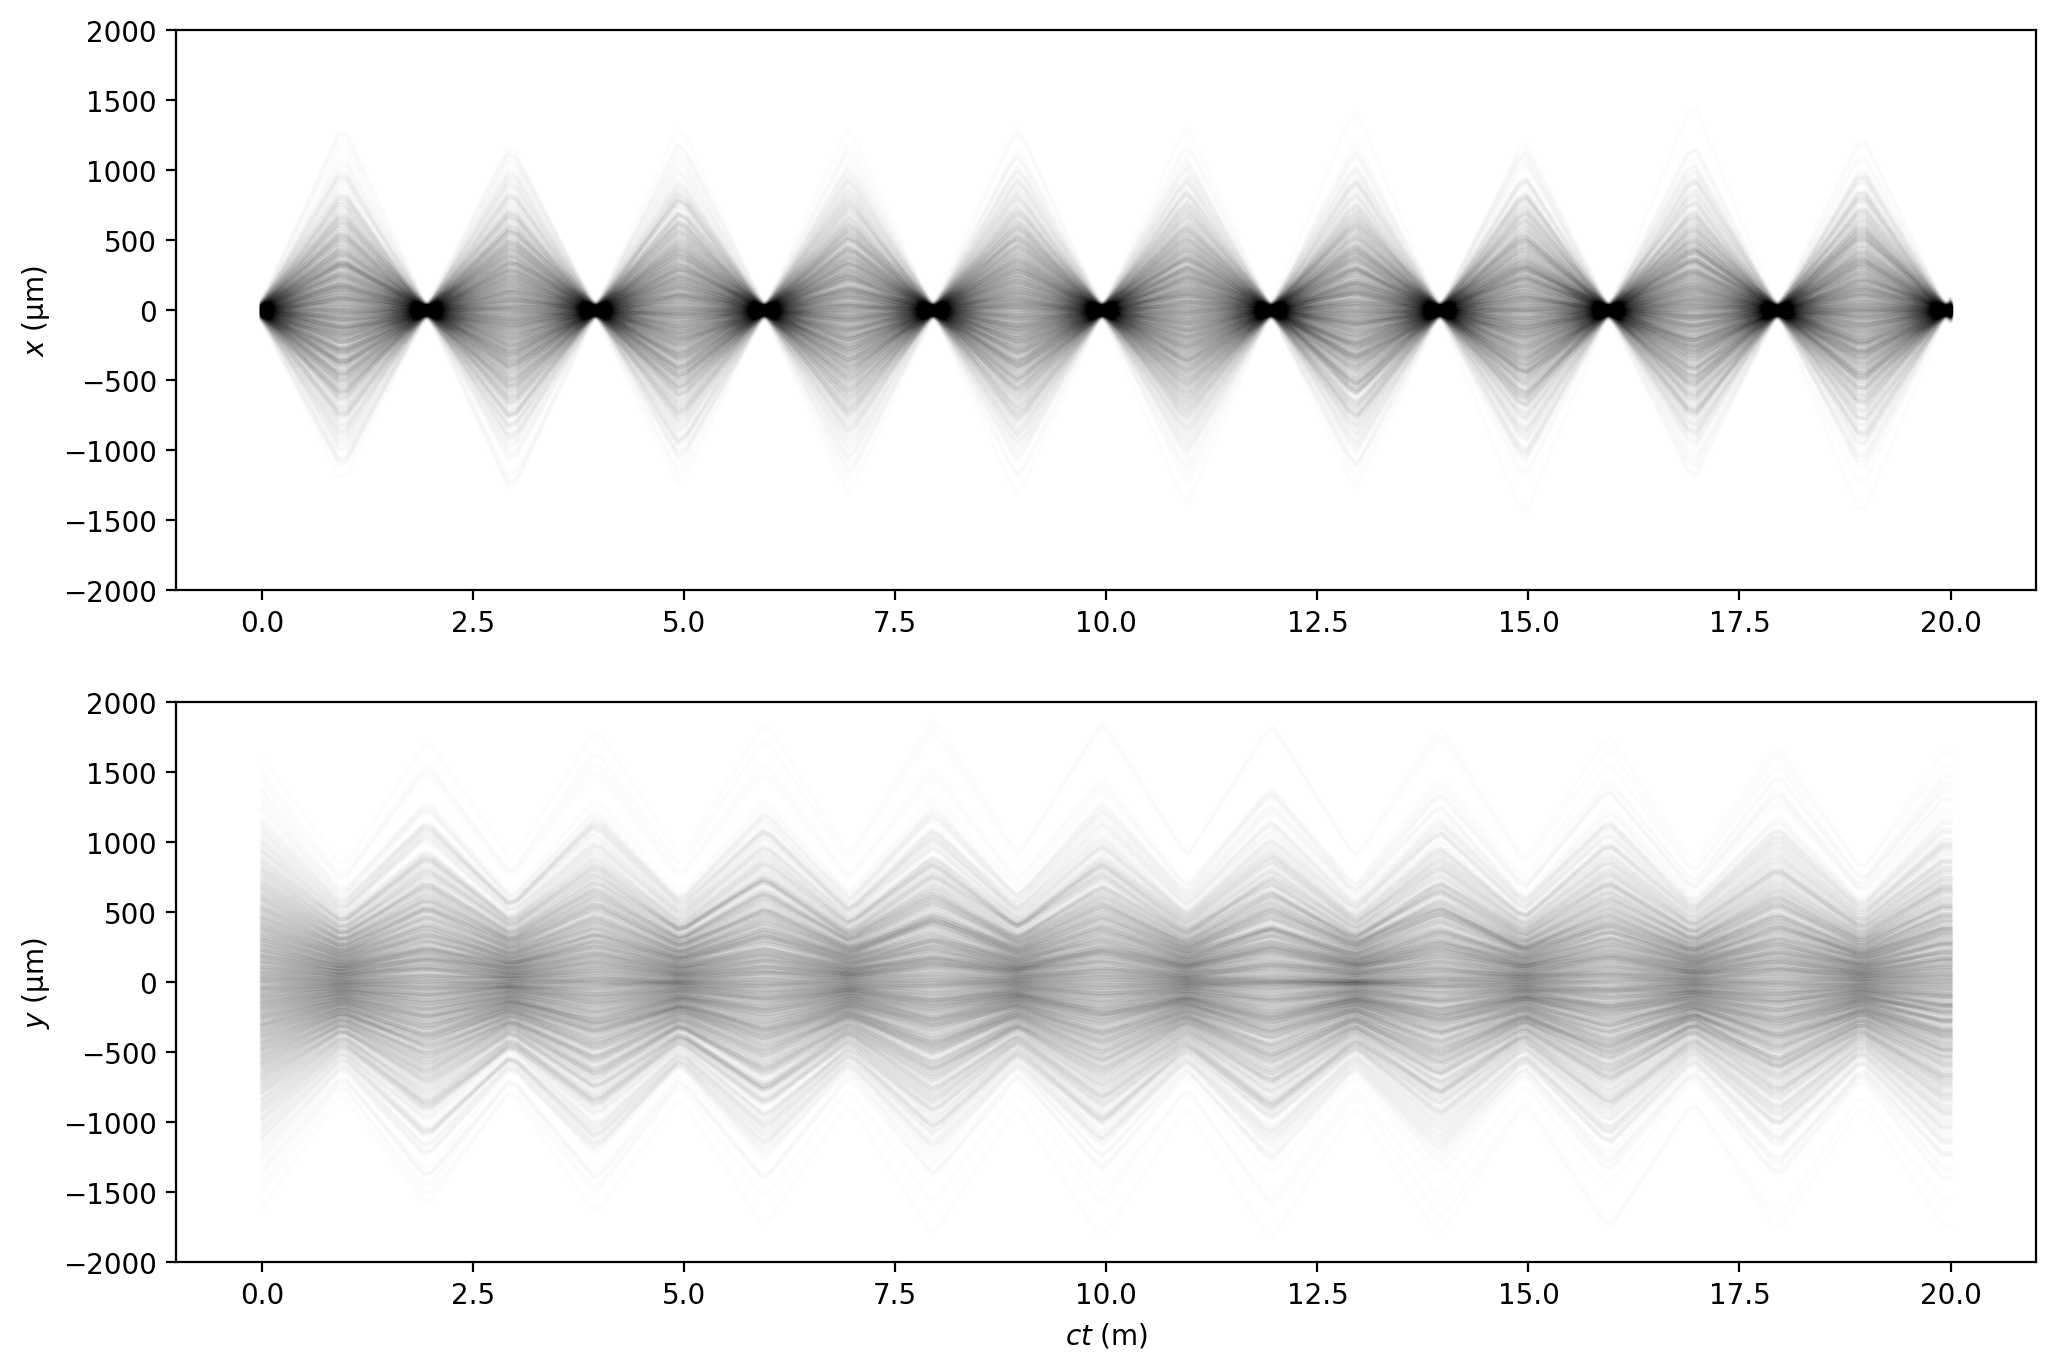

In [32]:
skip = 1  # make larger for faster plotting
fig, axes = plt.subplots(2, figsize=(12, 8))

axes[0].plot(
    [P.t[::skip] * 299792458 for P in Plist],
    [P.x[::skip] * 1e6 for P in Plist],
    alpha=0.01,
    color="black",
)

axes[1].plot(
    [P.t[::skip] * 299792458 for P in Plist],
    [P.y[::skip] * 1e6 for P in Plist],
    alpha=0.01,
    color="black",
)

axes[0].set_ylabel(r"$x$ (µm)")
axes[1].set_ylabel(r"$y$ (µm)")

axes[1].set_xlabel(r"$ct$ (m)")

for ax in axes:
    ax.set_ylim(-2000, 2000)

## Get some statistics

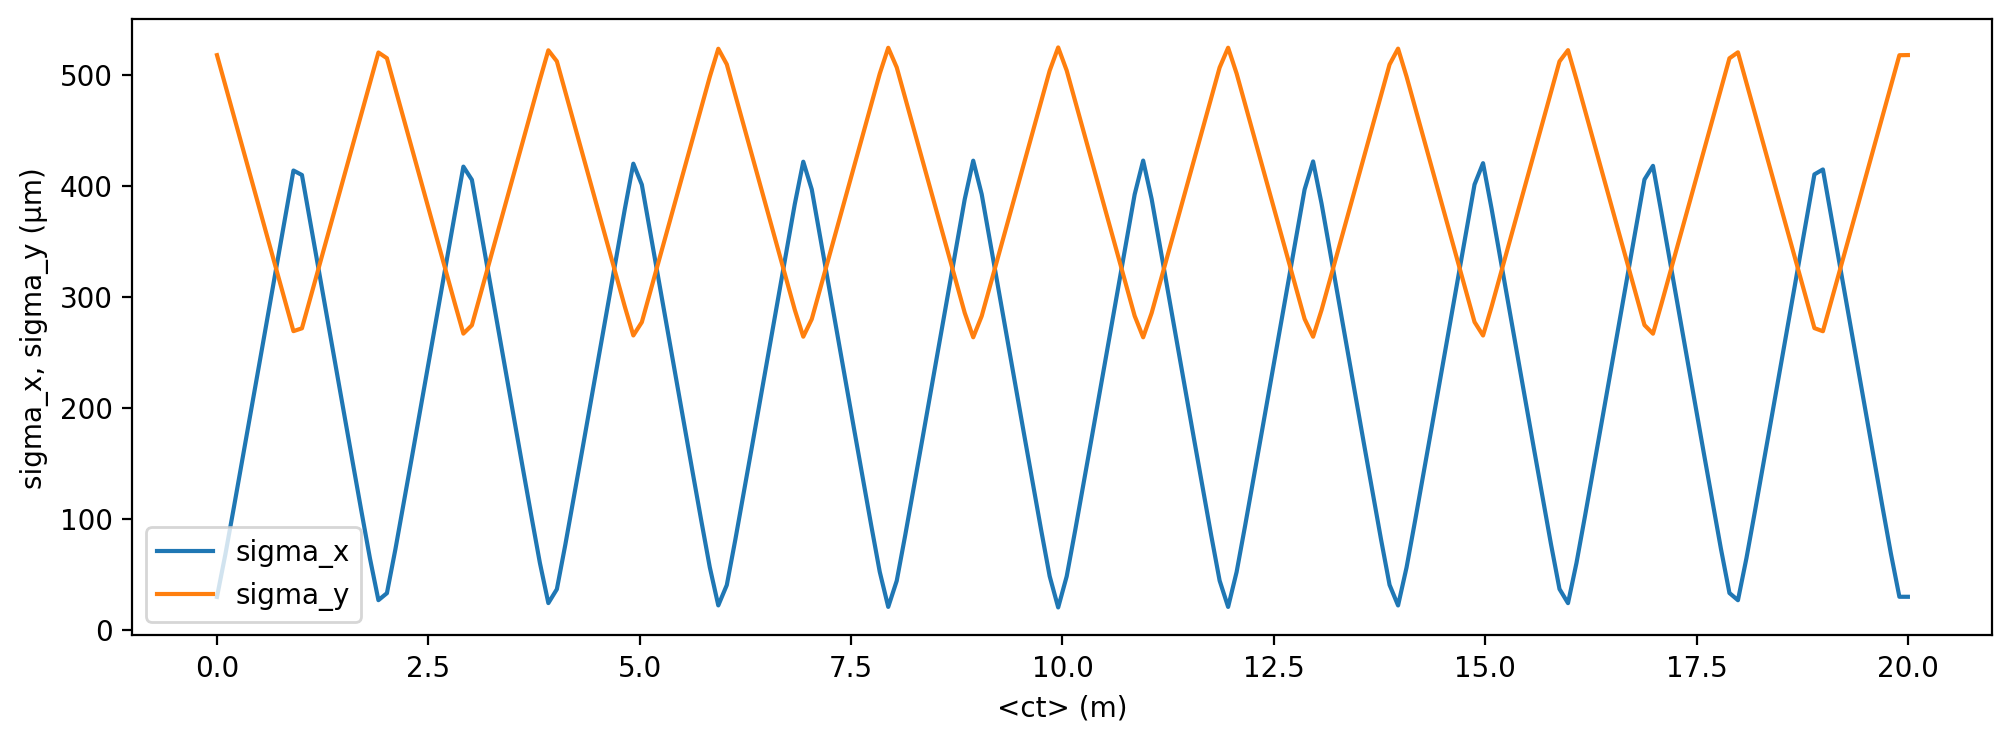

In [33]:
k1 = "sigma_x"
k2 = "sigma_y"

x = np.array([P["mean_t"] * 299792458 for P in Plist])
y1 = np.array([P[k1] for P in Plist])
y2 = np.array([P[k2] for P in Plist])

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(x, y1 * 1e6, label=k1)
ax.plot(x, y2 * 1e6, label=k2)
ax.set_xlabel("<ct> (m)")
ax.set_ylabel(f"{k1}, {k2} (µm)")
plt.legend()

## Cleanup

In [34]:
# Cleanup
!rm beam_dump.h5
!rm {latfile}
!rm markers.bmad